In [1]:
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.pde import solve2D, Monitor2D, PredefinedExampleGenerator2D
from neurodiffeq.pde import CustomBoundaryCondition, Point, DirichletControlPoint, NeumannControlPoint
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dirichlet_control_points = [
    DirichletControlPoint(
        loc=(0.5*np.cos(theta), 0.5*np.sin(theta)), 
        val=0.25
    )
    for theta in np.linspace(0, 2*np.pi, 50)
]

neumann_control_points = [
    NeumannControlPoint(
        loc=(np.cos(theta), np.sin(theta)), 
        val=2.0, 
        normal_vector=(np.cos(theta), np.sin(theta))
    )
    for theta in np.linspace(0, 2*np.pi, 50)
]
    
cbc = CustomBoundaryCondition( 
    dirichlet_control_points, 
    neumann_control_points, 
    center_point=Point((0.0, 0.0))
)

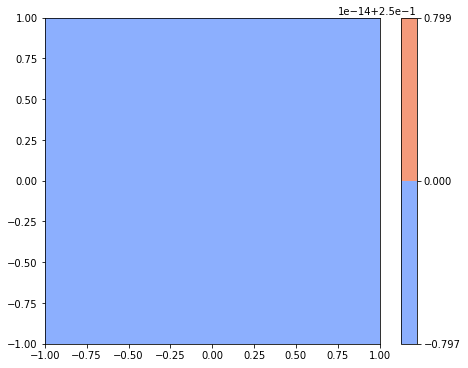

In [3]:
xs = torch.linspace(-1, 1, 101)
ys = torch.linspace(-1, 1, 101)
xx, yy = torch.meshgrid(xs, ys)
a_ds = cbc.a_d(xx, yy)
a_ds.detach().numpy()

fig, ax = plt.subplots(figsize=(7.5, 6))
cs = ax.contourf(xx, yy, a_ds, cmap='coolwarm')
cbar = fig.colorbar(cs)

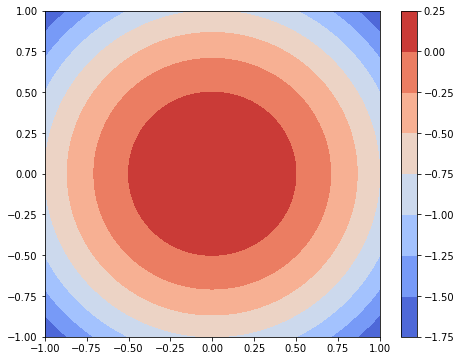

In [4]:
xs = torch.linspace(-1, 1, 101)
ys = torch.linspace(-1, 1, 101)
xx, yy = torch.meshgrid(xs, ys)
l_ds = cbc.l_d(xx, yy)
l_ds.detach().numpy()

fig, ax = plt.subplots(figsize=(7.5, 6))
cs = ax.contourf(xx, yy, l_ds, cmap='coolwarm')
cbar = fig.colorbar(cs)

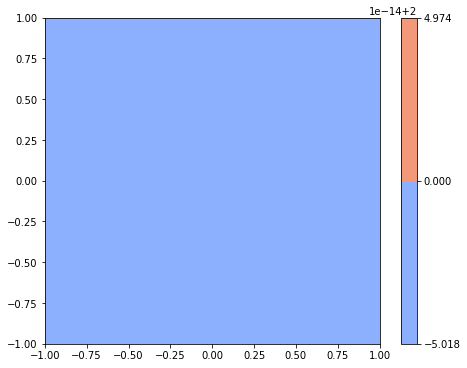

In [5]:
xs = torch.linspace(-1, 1, 101)
ys = torch.linspace(-1, 1, 101)
xx, yy = torch.meshgrid(xs, ys)
gs = cbc.g(xx, yy)
gs.detach().numpy()

fig, ax = plt.subplots(figsize=(7.5, 6))
cs = ax.contourf(xx, yy, gs, cmap='coolwarm')
cbar = fig.colorbar(cs)

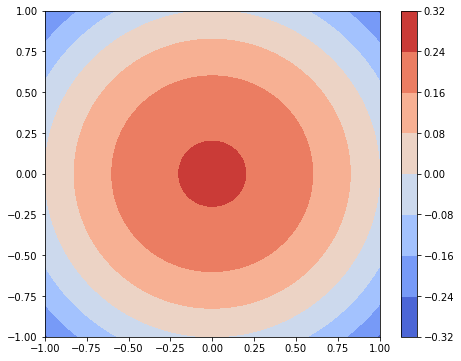

In [6]:
xs = torch.linspace(-1, 1, 101)
ys = torch.linspace(-1, 1, 101)
xx, yy = torch.meshgrid(xs, ys)
l_ms = cbc.l_m(xx, yy)
l_ms.detach().numpy()

fig, ax = plt.subplots(figsize=(7.5, 6))
cs = ax.contourf(xx, yy, l_ms, cmap='coolwarm')
cbar = fig.colorbar(cs)

In [7]:
xs, ys = np.linspace(-1.0, 1.0, 32), np.linspace(-1.0, 1.0, 32)
xx, yy = np.meshgrid(xs, ys)
in_domain = (xx**2 + yy**2 < 1.0) & (xx**2 + yy**2 > .25)
xx, yy = xx[in_domain], yy[in_domain]
train_gen = PredefinedExampleGenerator2D(xx, yy)

xs, ys = np.linspace(-1.0, 1.0, 100), np.linspace(-1.0, 1.0, 100)
xx, yy = np.meshgrid(xs, ys)
in_domain = (xx**2 + yy**2 < 1.0) & (xx**2 + yy**2 > .25)
xx, yy = xx[in_domain], yy[in_domain]
valid_gen = PredefinedExampleGenerator2D(xx, yy)

<IPython.core.display.Javascript object>


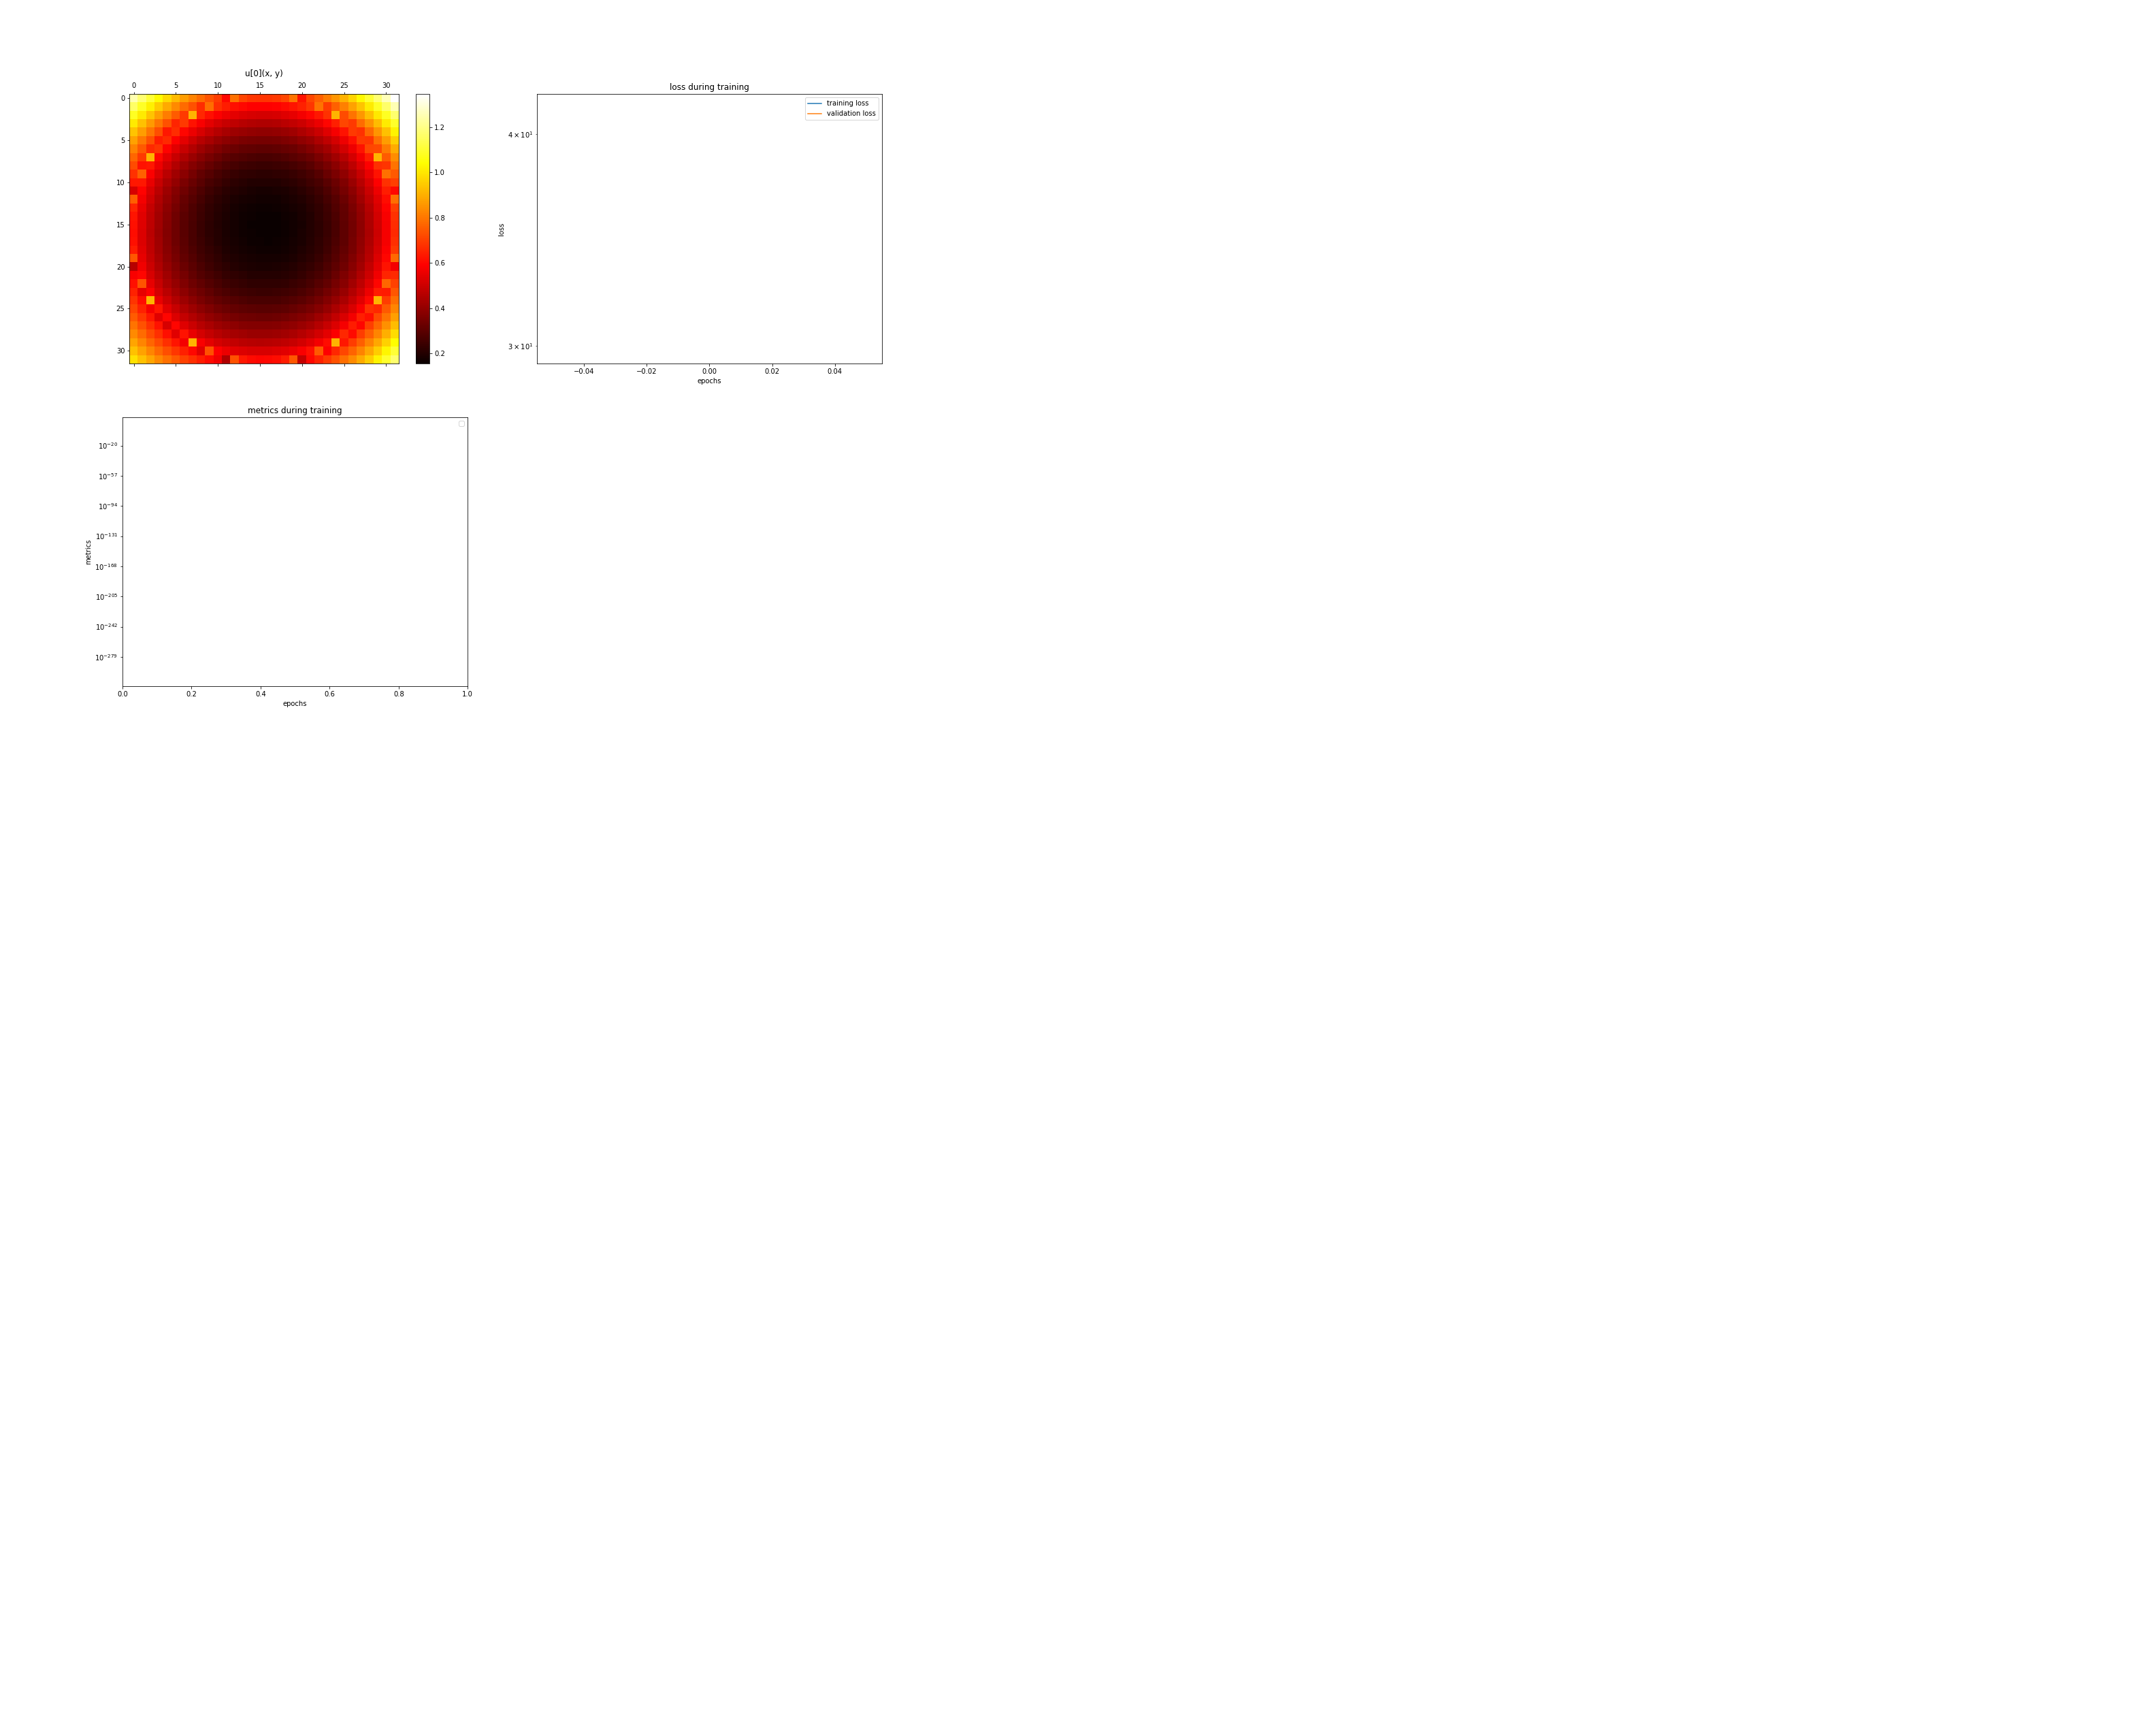

No handles with labels found to put in legend.


In [8]:
%matplotlib notebook
poisson = lambda u, x, y: diff(u, x, order=2) + diff(u, y, order=2) - 4
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=1, actv=nn.Softplus)
adam = optim.Adam(params=net.parameters(), lr=1e-2)

solution_neural_net_poisson, _ = solve2D(
    pde=poisson, condition=cbc, xy_min=(-1, -1), xy_max=(1, 1),
    net=net, optimizer=adam, 
    train_generator=train_gen, valid_generator=valid_gen,
    max_epochs=1, batch_size=train_gen.size,
    monitor=Monitor2D(check_every=1, xy_min=(-1, -1), xy_max=(1, 1))
)
%matplotlib inline

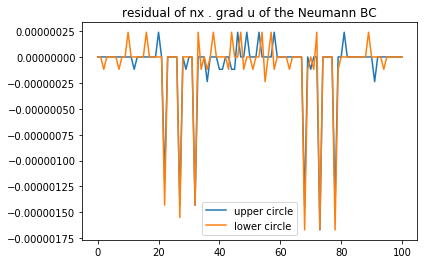

In [9]:
xs = np.linspace(-1, 1, 101, dtype=np.float32)
ys = np.sqrt(1.0-xs**2)
xs = torch.tensor(xs, requires_grad=True).reshape(-1, 1)
ys = torch.tensor(ys, requires_grad=True).reshape(-1, 1)

us = solution_neural_net_poisson(xs, ys)
nxgradu = xs * diff(us, xs) + ys * diff(us, ys)
plt.plot(nxgradu.detach().numpy() - 2.0, label='upper circle')

xs = np.linspace(-1, 1, 101, dtype=np.float32)
ys = -np.sqrt(1.0-xs**2)
xs = torch.tensor(xs, requires_grad=True).reshape(-1, 1)
ys = torch.tensor(ys, requires_grad=True).reshape(-1, 1)

us = solution_neural_net_poisson(xs, ys)
nxgradu = xs * diff(us, xs) + ys * diff(us, ys)
plt.plot(nxgradu.detach().numpy() - 2.0, label='lower circle')
plt.title('residual of nx . grad u of the Neumann BC')
plt.legend();

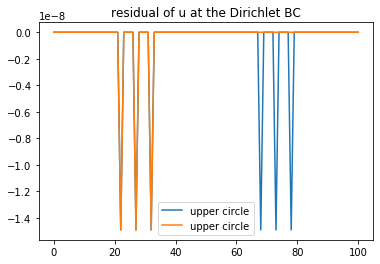

In [10]:
xs = np.linspace(-0.5, 0.5, 101, dtype=np.float32)
ys = np.sqrt(0.25-xs**2)
xs = torch.tensor(xs, requires_grad=True).reshape(-1, 1)
ys = torch.tensor(ys, requires_grad=True).reshape(-1, 1)

us = solution_neural_net_poisson(xs, ys)
nxgradu = xs * diff(us, xs) + ys * diff(us, ys)
plt.plot(us.detach().numpy() - 0.25, label='upper circle')

xs = np.linspace(-0.5, 0.5, 101, dtype=np.float32)
ys = -np.sqrt(0.25-xs**2)
xs = torch.tensor(xs, requires_grad=True).reshape(-1, 1)
ys = torch.tensor(ys, requires_grad=True).reshape(-1, 1)

us = solution_neural_net_poisson(xs, ys)
nxgradu = xs * diff(us, xs) + ys * diff(us, ys)
plt.plot(us.detach().numpy() - 0.25, label='upper circle')
plt.title('residual of u at the Dirichlet BC')
plt.legend();